<center>

# Discrete Event Systems

## Home Assignment 1

### Synchronization and Reachability Analysis

- - -

# Introduction

The objective of the home assignment is to get a deeper understanding of some basic features of discrete event systems. This will be achieved by implementing a few key functions in Python, including the computation of reachable and coreachable states, as well as the synchronous composition of two automata. These functions are then applied to the analysis of a simple coordination control system.

This home assignment is performend in *two member groups*. Write all your answers into this notebook and **submit only this notebook (.ipynb) on PingPong**

## Comments and Recommendations

* Whitespaces do matter in Python! Always check that you have the right amount of indentation. If you need a refresher on programming in Python check [this](https://wiki.python.org/moin/BeginnersGuide/Programmers) out, where you can find links to tutorials like [Google's Python class](https://developers.google.com/edu/python/). Wikipedia also has a great overview of [Python's syntax and semantics](https://en.wikipedia.org/wiki/Python_syntax_and_semantics). [learnpython.org](https://www.learnpython.org/) is a great resource too.
* We will work extensively with **sets** in this assignment. A set is created either through `set( )` or by listing its elements between curly braces `{*iterable*}`. An empty set must be created by `set()`. `{}` will create an empty dictionary. You will also see often something like `{elem for elem in items if elem}`. This is called a *set comprehension* and builds efficiently a new set by iterating over `items` and adding the `elem` for which the if-statement is true. Have an extensive look at [the set documentation](https://docs.python.org/3.6/library/stdtypes.html#set) for more information on set methods.  
* This assignment is written for Python 3.5 or later! Executing it with Python version 2.7 won't work.
* If you get stuck with Python or Jupyter, try to google it! E.g. your search query could be *"python --INSERT ERROR HERE--"*. Chances are high, heaps of people had the same problem before you.
* To show line numbers in a cell, go to *View* and click on *Toggle Line Numbers*.
* If your code passes all the tests in this notebook, you are on a good way. That does not mean you have passed though! We will test your code with additional edge cases. So convice yourself that everything is correct before you submit.

- - -

# Preliminaries

The code below defines the transition and the automaton class. Transitions are implemented as [named tuples](https://docs.python.org/3.6/library/collections.html?highlight=collections#collections.namedtuple). It also creates two automata **P1** and **P2**. You do not need to change anything here, but make sure you understand the code. 

In [20]:
from collections import namedtuple


Transition = namedtuple(typename='Transition', field_names=['source', 'event', 'target'])


class Automaton(object):
    
    def __init__(self, states, init, events, trans, marked=None, forbidden=None):
        """
        This is the constructor of the automaton. 
        
        At creation, the automaton gets the following attributes assigned:
        :param states: A set of states
        :param init: The initial state
        :param events: A set of events
        :param transitions: A set of transitions
        :param marked: (Optional) A set of marked states
        :param forbidden: (Optional) A set of forbidden states
        """
        self.states = self._validate_set(states)
        self.init = self._validate_init(init)
        self.events = self._validate_set(events)
        self.trans = self._validate_transitions(trans)
        self.marked = self._validate_subset(marked) if marked else set()
        self.forbidden = self._validate_subset(forbidden) if forbidden else set()
    
    def __str__(self):
        return 'states: \n\t{}\ninit: \n\t{}\nevents: \n\t{}\ntransitions: \n\t{}\nmarked: \n\t{}\nforbidden: \n\t{}\n'.format(
            self.states, self.init, self.events, '\n\t'.join([str(t) for t in self.trans]), self.marked, self.forbidden)
        
    @staticmethod
    def _validate_set(states):
        """
        Checks that states is a set and the states in it are strings or integers.
        """
        assert isinstance(states, set)
        for state in states:
            assert isinstance(state, str) or isinstance(state, int), 'A state must be \
                either of type string or integer!'
        return states
    
    def _validate_subset(self, subset):
        """
        Validates the set and checks whether the states in the subset are part of the state set.
        """
        subset = self._validate_set(subset)
        assert subset.issubset(self.states), 'Marked and forbidden states must be subsets of all states!'
        return subset
    
    def _validate_init(self, state):
        """
        Checks whether the state is part of the state set.
        """
        assert isinstance(state, str) or isinstance(state, int), 'The initial state must be of type string or integer!'
        assert state in self.states, 'The initial state must be member of states!'
        return state
    
    def _validate_transitions(self, transitions):
        """
        Checks that all transition elements are part in the respective sets (states, events). 
        """
        assert isinstance(transitions, set)
        for transition in transitions:
            assert isinstance(transition, Transition)
            assert transition.source in self.states
            assert transition.event in self.events
            assert transition.target in self.states
        return transitions


In [21]:
# Now we create an automaton with the following parameters

states = {'p11', 'p12'}
init = 'p11'
events = {'a', 'b'}
trans = {Transition('p11', 'a', 'p12'),
         Transition('p12', 'b', 'p11')}
marked = {'p11', 'p12'}

p1 = Automaton(states, init, events, trans, marked)
print(p1)

states: 
	{'p11', 'p12'}
init: 
	p11
events: 
	{'a', 'b'}
transitions: 
	Transition(source='p12', event='b', target='p11')
	Transition(source='p11', event='a', target='p12')
marked: 
	{'p11', 'p12'}
forbidden: 
	set()



P1:


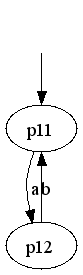

In [22]:
from util import plot_automaton

print('P1:')
plot_automaton(automaton=p1, file_name_no_extension='P1')  

P2:


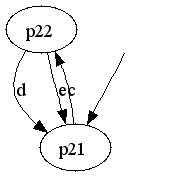

In [23]:
# We create a second automaton
p2 = Automaton(states={'p21', 'p22'},
               init='p21',
               events={'c', 'd', 'e'},
               trans={Transition('p21', 'c', 'p22'),
                      Transition('p22', 'd', 'p21'),
                      Transition('p22', 'e', 'p21')},
               marked={'p21', 'p22'})
print('P2:')
plot_automaton(p2, 'P2') # If this command is the last line in the cell, you can see the figure here!

- - -

# Task 1

## Task 1.1 - Reachability

Now that we know how to create automata, lets start with implementing the reachability function.

As defined in chapter 6 of the lecture notes the reachability algorithm is as follows:

**Algorithm 1.** Reachability($\Sigma, \delta, Q_0, Q_x$)

>**let** $k:=0, Q_0 := Q_0 \setminus Q_x$
>
>**repeat**
>
>>$k := k+1$
>>
>>$Q_k := Q_{k-1} \cup \{q^+ \mid \exists q \in Q_{k-1} \wedge \exists \sigma \in \Sigma \wedge \delta(q,\sigma) = q^+ \} \setminus Q_x $
>>
>**until** $Q_k = Q_{k-1}$
>
**return** $Q_k$

This is a so called fix point operation.

* Describe in words how this algorithm works. You can enter your answer in the cell below. [Markdown](https://daringfireball.net/projects/markdown/syntax) and [LaTex's math environment](https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols) (the \$ \$ environment) are supported. To edit the answer, double-click on "YOUR ANSWER HERE" in the cell below.

YOUR ANSWER HERE

Here are some helper functions that might help you with your implementation of the algorithm in code.

In [24]:
def filter_trans_by_source(trans, states_to_keep):
    """Returns a new set containing all transitions where the source is in states_to_keep"""
    return {t for t in trans if t.source in states_to_keep}

def filter_trans_by_events(trans, events_to_keep):
    """Returns a new set containing all transitions where the event is in events_to_keep"""
    return {t for t in trans if t.event in events_to_keep}

def filter_trans_by_target(trans, states_to_keep):
    """Returns a new set containing all transitions where the target is in states_to_keep"""
    return {t for t in trans if t.target in states_to_keep}

def extract_elems_from_trans(trans, field):
    """ 
    Returns a new set with just the elements in a field of all transitions. 
    E.g. field='source' for all source states 
    or field='event' or field='target'
    """
    return {getattr(t, field) for t in trans}

def flip_trans(trans):
    """ Flips the direction of the transitions in the set"""
    return {Transition(t.target, t.event, t.source) for t in trans}

In [25]:
# Now implement the function in code
def reach(events, trans, start_states, forbidden):
    """
    Returns the forward reachable states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """
    def reach_rec(events, trans, start_states, forbidden, path):  # recursive function with path as extra argument
        next_trans = filter_trans_by_source(trans, start_states)
        next_states = extract_elems_from_trans(next_trans, 'target') - forbidden
        if next_states.issubset(path): 
            return path  # stop recursion
        return reach_rec(events, trans, next_states, forbidden, path.union(next_states))
    return reach_rec(events, trans, start_states-forbidden, forbidden, start_states-forbidden)

This below is a test cell. You can execute it to test your function with different inputs. The **assert** statements make sure that your function returns the expected results.

In [26]:
# Single state
assert reach(set(), set(),{1}, set()) == {1}
assert reach({'a'}, {Transition(1, 'a', 1)}, {1}, set()) == {1}

# Simple automata
assert reach({'a'}, {Transition(1, 'a', 2)}, {1}, set()) == {1, 2}
assert reach({'a'}, {Transition(2, 'a', 1)}, {1}, set()) == {1}
assert reach({'a'}, {Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}, set()) == {1, 2}

# Parallel transitions
assert reach({'a', 'b'}, {Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}, set()) == {1, 2}
assert reach({'a', 'b'}, {Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}, set()) == {1}

# Handling of forbidden states
assert reach({'a'}, {Transition(1, 'a', 2)}, {1}, {1}) == set()
assert reach({'a'}, {Transition(1, 'a', 2)}, {1}, {2}) == {1}

# Larger automata
assert reach({'a'}, 
             {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
             {1},
             set()) == {1, 2, 3}

## Task 1.2 - Coreachability

Similarly, the set of backwards reachable states is defined as:

**Algorithm 2.** BackwardReachability($\Sigma, \delta, Q_0, Q_x$)

>**let** $k:=0, Q_0 := Q_0 \setminus Q_x$
>
>**repeat**
>
>>$k := k+1$
>>
>>$Q_k := Q_{k-1} \cup \{q \mid \exists \sigma \in \Sigma \wedge \delta(q,\sigma) \in Q_{k-1} \} \setminus Q_x $
>>
>**until** $Q_k = Q_{k-1}$
>
**return** $Q_k$

* Implement Algorithm 2.

In [27]:
def coreach(events, trans, start_states, forbidden):
    """
    Returns the coreachable (backward reachable) states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """
    def coreach_rec(events, trans, start_states, forbidden, path):
        next_trans = filter_trans_by_target(trans, start_states)
        next_states = extract_elems_from_trans(next_trans, 'source') - forbidden
        if next_states.issubset(path): 
            return path
        return coreach_rec(events, trans, next_states, forbidden, path.union(next_states))
    return coreach_rec(events, trans, start_states-forbidden, forbidden, start_states-forbidden)

In [28]:
# Single state
assert coreach(set(), set(),{1}, set()) == {1}
assert coreach({'a'}, {Transition(1, 'a', 1)}, {1}, set()) == {1}

# Simple automata
assert coreach({'a'}, {Transition(2, 'a', 1)}, {2}, set()) == {2}
assert coreach({'a'}, {Transition(2, 'a', 1)}, {1}, set()) == {1, 2}
assert coreach({'a'}, {Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}, set()) == {1, 2}

# Parallel transitions
assert coreach({'a', 'b'}, {Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}, set()) == {1}
assert coreach({'a', 'b'}, {Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}, set()) == {1, 2}

# Handling of forbidden states
assert coreach({'a'}, {Transition(1, 'a', 2)}, {1}, {1}) == set()
assert coreach({'a'}, {Transition(2, 'a', 1)}, {1}, {2}) == {1}

# Larger automata
assert coreach({'a'}, 
               {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
               {1},
               set()) == {1, 2, 3}

## Task 1.3 - Synchronous composition
* Implement the synchronous composition of two automaton. Exclude all unreachble states in the result.

* *Note:* The synchronization function can be implemented in different ways. We suggest to loop through all events, taking common and individual events for the two automata into account. In this event loop appropriate states are merged together according to the basic definition. A number of unreachable states will then be included.   
* *Note:* The synchronized function shall include the complete automaton, including any marked and forbidden states of the synchronized automaton.

Here are again some helper functions that might help you with your implementation of the algorithm in code.

In [29]:
def merge_label(label1, label2):
    """Creates a new label based on two labels"""
    return '{}.{}'.format(label1, label2)

def cross_product(setA, setB):
    """Computes the crossproduct of two sets"""
    return {merge_label(a, b) for b in setB for a in setA}

In [227]:
def synch(aut1, aut2):
    """
    Returns the synchronous composition of two automata.
    
    :param aut1: Automaton
    :param aut2: Automaton
    """
    init12 = merge_label(aut1.init, aut2.init) 
    events12 = extract_elems_from_trans(aut1.trans,'event') | extract_elems_from_trans(aut2.trans,'event')
    trans12 = set()
        
    for ev in events12:
        if ev not in aut1.events:
            aut1.trans = aut1.trans | {Transition(st1, ev, st1) for st1 in aut1.states }
        if ev not in aut2.events:
            aut2.trans = aut2.trans | {Transition(st2, ev, st2) for st2 in aut2.states }
        for tr1 in filter_trans_by_events( aut1.trans, {ev} ):
            for tr2 in filter_trans_by_events( aut2.trans, {ev} ):
                origin = merge_label( extract_elems_from_trans({tr1},'source').pop(), extract_elems_from_trans({tr2},'source').pop() )
                target = merge_label( extract_elems_from_trans({tr1},'target').pop(), extract_elems_from_trans({tr2},'target').pop() )
                trans12.add( Transition( origin, ev, target ) )
 
    states12    = extract_elems_from_trans(trans12,'source') | extract_elems_from_trans(trans12,'target') | {init12} #cross_product(aut1.states, aut2.states)
    forbidden12 = cross_product(aut1.forbidden, aut2.states) | cross_product(aut1.states, aut2.forbidden) & states12
    marked12    = cross_product( aut1.marked if aut1.marked else aut1.states, aut2.marked if aut2.marked else aut2.states) & states12    
    
    
    print("STATES={}, MARKED={}, FORBIDDEN={}".format(states12, marked12, forbidden12))
    
    Q12 = Automaton( states=states12, init=init12, events=events12, trans=trans12, forbidden=forbidden12, marked=marked12 )
    return Q12



a1 = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)

print(a1a2)

assert a1a2.states == {'1.3', '2.3'} # TC - 9.1
assert a1a2.init == '1.3' # TC - 9.2
assert a1a2.events == {'a', 'b'} # TC - 9.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 9.4
assert a1a2.marked == {'2.3'} # TC - 9.5


STATES={'1.4', '1.3', '2.4', '2.3'}, MARKED={'2.3', '2.4'}, FORBIDDEN=set()
states: 
	{'1.4', '1.3', '2.4', '2.3'}
init: 
	1.3
events: 
	{'a', 'b'}
transitions: 
	Transition(source='1.4', event='a', target='2.4')
	Transition(source='1.3', event='a', target='2.3')
marked: 
	{'2.3', '2.4'}
forbidden: 
	set()



AssertionError: 

In [225]:
# Two 1-state automata
a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set())
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'} # TC - 1.1
assert a1a2.init == '1.2' # TC - 1.2
assert a1a2.events == set() # TC - 1.3
assert a1a2.trans == set() # TC - 1.4

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               marked={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'} # TC - 2.1
assert a1a2.init == '1.2' # TC - 2.2
assert a1a2.events == set() # TC - 2.3
assert a1a2.trans == set() # TC - 2.4
assert a1a2.marked == {'1.2'} # TC - 2.5

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               forbidden={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'} # TC - 3.1
assert a1a2.init == '1.2' # TC - 3.2
assert a1a2.events == set() # TC - 3.3
assert a1a2.trans == set() # TC - 3.4
assert a1a2.forbidden == {'1.2'} # TC - 3.5

# 2-state automaton and 1-state automaton
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'} # TC - 4.1
assert a1a2.init == '1.3' # TC - 4.2
assert a1a2.events == {'a'} # TC - 4.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 4.4
assert a1a2.marked == {'2.3'} # TC - 4.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'} # TC - 5.1
assert a1a2.init == '1.3' # TC - 5.2
assert a1a2.events == {'a'} # TC - 5.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 5.5
assert a1a2.forbidden == {'2.3'} # TC - 5.6

# Two 2-state automata
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'} # TC - 6.1
assert a1a2.init == '1.3' # TC - 6.2
assert a1a2.events == {'a', 'b'} # TC - 6.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition('1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')} # TC -6.4
assert a1a2.marked == {'2.3', '2.4'} # TC - 6.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'a'},
               trans={Transition(3, 'a', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.4'} # TC - 7.1
assert a1a2.init == '1.3' # TC - 7.2
assert a1a2.events == {'a'} # TC - 7.3
assert a1a2.trans == {Transition('1.3', 'a', '2.4')} # TC - 7.4
assert a1a2.marked == {'2.4'} # TC - 7.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)},
               forbidden={4})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'} # TC - 8.1
assert a1a2.init == '1.3' # TC - 8.2
assert a1a2.events == {'a', 'b'} # TC - 8.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition('1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')} # TC - 8.4
assert a1a2.forbidden == {'2.3', '1.4', '2.4'} # TC - 8.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'} # TC - 9.1
assert a1a2.init == '1.3' # TC - 9.2
assert a1a2.events == {'a', 'b'} # TC - 9.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 9.4
assert a1a2.marked == {'2.3'} # TC - 9.5


STATES={'1.2'}, MARKED={'1.2'}, FORBIDDEN=set()
STATES={'1.2'}, MARKED={'1.2'}, FORBIDDEN=set()
STATES={'1.2'}, MARKED={'1.2'}, FORBIDDEN={'1.2'}
STATES={'2.3', '1.3'}, MARKED={'2.3'}, FORBIDDEN=set()
STATES={'2.3', '1.3'}, MARKED={'2.3', '1.3'}, FORBIDDEN={'2.3'}
STATES={'1.4', '1.3', '2.4', '2.3'}, MARKED={'2.3', '2.4'}, FORBIDDEN=set()
STATES={'1.3', '2.4'}, MARKED={'2.4'}, FORBIDDEN=set()
STATES={'1.4', '1.3', '2.4', '2.3'}, MARKED={'2.3', '1.4', '1.3', '2.4'}, FORBIDDEN={'1.4', '2.3', '2.4'}
STATES={'1.4', '1.3', '2.4', '2.3'}, MARKED={'2.3', '2.4'}, FORBIDDEN=set()


AssertionError: 

- - -

# Task 2

Consider the following two plant models given by the formal languages

<center>
    $L(P_1) = \overline{(ab)^*} \\
    L(P_2) = \overline{(c(d+e))^*}$

and the marked specification languages 

<center>
    $L(Sp_1) = (bc)^* \\
    L(Sp_2) = (cd)^*$
    
and the synchronised system

<center>
    $S = P_1 \parallel P_2 \parallel Sp_1 \parallel Sp_2$
    
The plant models are already defined as automaton ***p1*** and ***p2*** above.

## Task 2.1 - Petri Net

* Formulate a Petri net for the synchronized sytem *S*  
* and generate the corresponding reachability graph.
* *Note:* It might be easier to first draw those with a pen on paper and then transfer it into the notebook.

In [ ]:
from util import plot_petrinet

PetriNet = namedtuple(typename='PetriNet', field_names=['places', 'transitions', 'arcs'])
Place = namedtuple('Place', ['label', 'marking'])
Arc = namedtuple('Arc', ['source', 'target', 'weight'])

# You can use the ploting function to plot your petri net for S
example = PetriNet(places={Place('p1', 1), Place('p2', 0)}, 
                   transitions={'t1'}, 
                   arcs={Arc('p1', 't1', 1), Arc('t1', 'p2', 1)})
plot_petrinet(example, 'example')

In [ ]:
def make_synchronized_petri_net_S():
    """
    A little helper function to create the Petri net of S.
    
    You can just hard code the elements of the net just like in the example above.
    We will call this function later in the tests.
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return S

plot_petrinet(make_synchronized_petri_net_S(), 'S_petrinet')

In [ ]:
S = make_synchronized_petri_net_S()
assert isinstance(S, PetriNet)
assert isinstance(S.places.pop(), Place)
assert isinstance(S.arcs.pop(), Arc)


Similarly, we create the reachability graph.

In [ ]:
from util import plot_digraph

DiGraph = namedtuple(typename='DiGraph', field_names=['nodes', 'init', 'edges'])
Edge = namedtuple('Edge', ['source', 'target', 'label'])

# You can use the ploting function to plot your reachability graph for S
example = DiGraph(nodes={1, 2},
                  init=1,
                  edges={Edge(1, 2, 'a')})
plot_digraph(example, 'example')

In [ ]:
def make_reachability_graph():
    """
    A little helper function to create the reachability graph of S.
    
    You can just hard code the elements of the graph just like in the example above.
    We will call this function later in the tests.
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return G

plot_digraph(make_reachability_graph(), 'S_reach_graph')

In [ ]:
G = make_reachability_graph()
assert isinstance(G, DiGraph)
assert isinstance(G.nodes, set)
assert isinstance(G.edges.pop(), Edge)


## Task 2.2 - Synchronized Automaton

* Generate the automaton for the synchronized system *S* by the implemented functions `synch`, 
* and compare the results with the reachbility graph in **2.1**.

In [ ]:
def make_synchronized_automaton_S():
    """
    A little helper function to create the automaton of S.
    
    Define the automata sp1 and sp2 in here too.
    We will call this function later in the tests.
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return S

plot_automaton(make_synchronized_automaton_S(), 'P1P2SP1SP2')

In [ ]:
S = make_synchronized_automaton_S()
assert S.init == 'p11.p21.sp11.sp21', 'Please, follow the synchronization order specified in Task 2!'


Compare the synchronized automaton of *S* to the reachability graph.

YOUR ANSWER HERE

## Task 2.3 - Blocking states

* Calculate the reachable and coreachable states in *S* by the implemented functions `reach` and `coreach`, and identify blocking states (states from where no marked state can be reached).

In [ ]:
reachable = None
coreachable = None 
blocking = None
# YOUR CODE HERE
raise NotImplementedError()

print('The blocking states are: ', blocking)

In [ ]:
assert reachable is not None
assert coreachable is not None
assert blocking is not None


## Task 2.4 - Modified Spec

* Modify the specifications to avoid the blocking states, and verify that no blocking states are achieved by showing that the reachable and coreachable states of *S* are the same for the modified specifications.
* Explain your modifications first in natural language.

YOUR ANSWER HERE

In [ ]:
sp1_new = None

# YOUR CODE HERE
raise NotImplementedError()

plot_automaton(sp1_new, 'SP1_new') 

In [ ]:
sp2_new = None

# YOUR CODE HERE
raise NotImplementedError()

plot_automaton(sp2_new, 'SP2_new') 

In [ ]:
# Now synchronize with the new specifications
S_new = synch(synch(p1, p2), synch(sp1_new, sp2_new))

reachable_new = None
coreachable_new = None 
blocking_new = None
# YOUR CODE HERE
raise NotImplementedError()

print('The blocking states now are: ', blocking_new)
plot_automaton(S_new, 'S_new') 

In [ ]:
assert reachable_new is not None
assert coreachable_new is not None
assert blocking_new is not None


- - -

Congratulations! You have reached the end of the assignment. Now,

* Save the notebook
* Upload the .ipynb file to Ping Pong
* Enjoy the rest of the day! 